# section I

In [7]:
!pip install earthengine-api geemap folium matplotlib pandas geopandas rasterio rasterstats

In [9]:
!earthengine authenticate

Authenticate: Credentials already exist.  Use --force to refresh.


In [1]:
my_project = 'my-project-000000000000'

In [ ]:
# Code Snippet 1.1: Initializing and Testing the GEE Python API
import ee

# Initialize the library
try:
    ee.Initialize(project=my_project)
    print(f"Earth Engine {my_project} initialized successfully!")
    
    # Test with a simple operation
    image = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_044034_20200926')
    print(f"Test image has {image.bandNames().size().getInfo()} bands")
    
except Exception as e:
    print(f"Initialization failed: {e}")

In [51]:
# Option 1: Define a geometry directly from coordinates
aoi_polygon = ee.Geometry.Polygon(
    [[[-74.1, 4.0],
      [-73.9, 4.0],
      [-73.9, 4.2],
      [-74.1, 4.2]]])
# Option 2: Upload or use a vector dataset

In [4]:
# This function filters the Landsat 8 collection for a specific region and time,
# selecting only images with low cloud cover to ensure data quality.
region = ee.Geometry.Polygon([[[-74.1, 4.0], [-73.9, 4.0], [-73.9, 4.2], [-74.1, 4.2]]])

collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
               .filterBounds(region)
               .filterDate('2023-01-01', '2023-12-31')
               .filterMetadata('CLOUD_COVER', 'less_than', 30))

# Print the number of images found to verify the filter.
# .size() is a server-side function; .getInfo() brings the result to the client.
print('Number of images in collection:', collection.size().getInfo())

Number of images in collection: 3


In [5]:
# Define a function to calculate and add an NDVI band.
def add_ndvi(image):
    # Calculate NDVI using the server-side normalizedDifference() function.
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    # Add the NDVI band to the image.
    return image.addBands(ndvi)



In [6]:
# Map the function over the entire collection.
ndvi_collection = collection.map(add_ndvi)

In [7]:
# Reduce the collection to a single image by taking the median of all pixel values.
# We also select just the NDVI band for our final output.
ndvi_median = ndvi_collection.select('NDVI').median()

In [8]:
# Define the export task.
task = ee.batch.Export.image.toDrive(
    image=ndvi_median.clip(region),  # Clip the image to our AOI
    description='NDVI_Median_2023',
    folder='GEE_Exports',
    scale=30,  # Spatial resolution in meters (matches Landsat)
    region=region
)
# Start the export task. You can monitor its progress in the GEE Code Editor's 'Tasks' tab.
task.start()
print("Export task started.")

Export task started.


average 0.2134728729724884


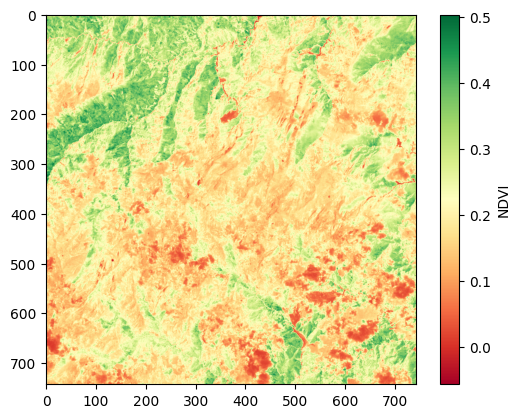

In [11]:
# Import libraries
import geemap
import matplotlib.pyplot as plt

# Suppose ndvi_median is your ee.Image
ndvi_median_clipped = ndvi_median.clip(region)

# Convert to numpy array
array = geemap.ee_to_numpy(ndvi_median_clipped, region=region, scale=30)

# Print the average value
print(f"average {array.mean()}")

# Plot
plt.imshow(array, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.show()

Found 3 images meeting criteria


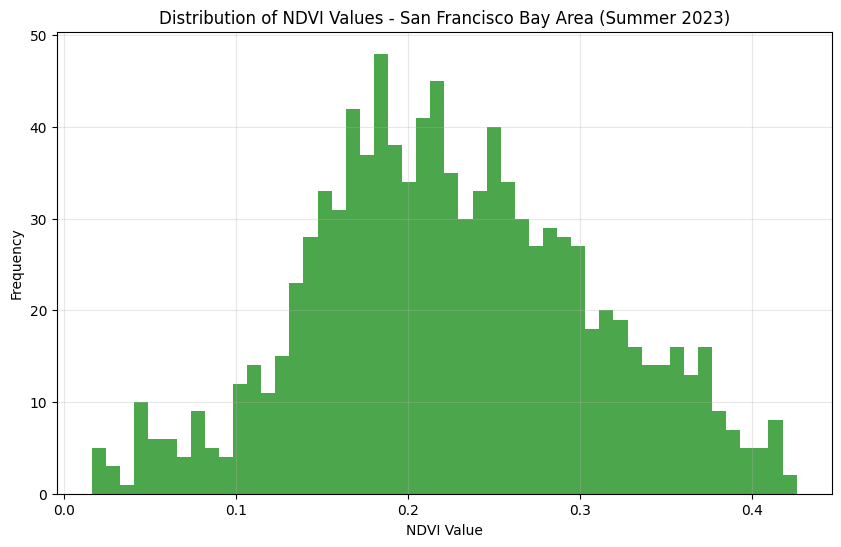

Mean NDVI: 0.226
Standard deviation: 0.082


In [17]:
import ee
import matplotlib.pyplot as plt
import numpy as np

# Initialize Earth Engine with Project context
ee.Initialize(project='my-project-0000000000')

# Define study area (San Francisco Bay Area)
geometry = ee.Geometry.Rectangle([-74.1, 4.0, -73.9, 4.2])

# Load and filter Landsat 8 imagery
collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(geometry) \
    .filterDate('2023-01-01', '2023-12-31') \
    .filter(ee.Filter.lt('CLOUD_COVER', 30))

print(f"Found {collection.size().getInfo()} images meeting criteria")

# Create median composite
median_image = collection.median()

# Calculate NDVI
ndvi = median_image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

# Sample NDVI values within the geometry
ndvi_sample = ndvi.sample(
    region=geometry,
    scale=30,
    numPixels=1000,
    geometries=True
)

# Get the sample data and convert to pandas for visualization
sample_data = ndvi_sample.getInfo()
ndvi_values = [feature['properties']['NDVI'] for feature in sample_data['features']]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(ndvi_values, bins=50, alpha=0.7, color='green')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.title('Distribution of NDVI Values - San Francisco Bay Area (Summer 2023)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean NDVI: {np.mean(ndvi_values):.3f}")
print(f"Standard deviation: {np.std(ndvi_values):.3f}")

In [46]:
def calculate_comprehensive_indices(image):
    """
    Calculates a comprehensive suite of spectral indices for multi-faceted analysis.
    """
    # Normalized bands for easier calculation
    blue = image.select('SR_B2').multiply(0.0000275).add(-0.2)
    green = image.select('SR_B3').multiply(0.0000275).add(-0.2)
    red = image.select('SR_B4').multiply(0.0000275).add(-0.2)
    nir = image.select('SR_B5').multiply(0.0000275).add(-0.2)
    swir1 = image.select('SR_B6').multiply(0.0000275).add(-0.2)
    swir2 = image.select('SR_B7').multiply(0.0000275).add(-0.2)
    
    # Vegetation indices
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    
    evi = nir.subtract(red).divide(
        nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1)
    ).multiply(2.5).rename('EVI')
    
    savi = nir.subtract(red).divide(nir.add(red).add(0.5)).multiply(1.5).rename('SAVI')
    
    # Moisture indices
    ndmi = nir.subtract(swir1).divide(nir.add(swir1)).rename('NDMI')
    msi = swir1.divide(nir).rename('MSI')
    
    # Water indices
    ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
    mndwi = green.subtract(swir1).divide(green.add(swir1)).rename('MNDWI')
    
    # Soil indices
    nbr = nir.subtract(swir2).divide(nir.add(swir2)).rename('NBR')
    ndbi = swir1.subtract(nir).divide(swir1.add(nir)).rename('NDBI')
    
    return image.addBands([ndvi, evi, savi, ndmi, msi, ndwi, mndwi, nbr, ndbi])
    
def advanced_cloud_mask(image):
    """
    Implements multi-criteria cloud and shadow masking for Landsat 8/9.
    Combines pixel QA, spectral tests, and contextual filtering.
    """
    qa_pixel = image.select('QA_PIXEL')
    qa_radsat = image.select('QA_RADSAT')
    
    # Basic cloud and shadow masking from QA_PIXEL
    cloud_mask = qa_pixel.bitwiseAnd(1 << 3).eq(0)  # Cloud confidence
    shadow_mask = qa_pixel.bitwiseAnd(1 << 4).eq(0)  # Cloud shadow confidence
    snow_mask = qa_pixel.bitwiseAnd(1 << 5).eq(0)   # Snow/ice confidence
    
    # Additional spectral-based tests
    blue = image.select('SR_B2').multiply(0.0000275).add(-0.2)
    green = image.select('SR_B3').multiply(0.0000275).add(-0.2)
    red = image.select('SR_B4').multiply(0.0000275).add(-0.2)
    nir = image.select('SR_B5').multiply(0.0000275).add(-0.2)
    swir1 = image.select('SR_B6').multiply(0.0000275).add(-0.2)
    
    # White cloud test: high reflectance in visible bands
    white_test = blue.gt(0.2).And(green.gt(0.2)).And(red.gt(0.2))
    
    # Hot pixel test: very high SWIR relative to NIR (potential cloud)
    hot_test = swir1.divide(nir).gt(1.5)
    
    # Cold pixel test: very low temperature (potential high cloud)
    if image.bandNames().contains('ST_B10'):
        temp = image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15)
        cold_test = temp.lt(-10)
    else:
        cold_test = ee.Image.constant(0)
    
    # Combine all quality tests
    comprehensive_mask = cloud_mask.And(shadow_mask).And(snow_mask) \
        .And(white_test.Not()).And(hot_test.Not()).And(cold_test.Not())
    
    # Radiometric saturation check
    saturated_mask = qa_radsat.eq(0)  # No saturated pixels
    
    final_mask = comprehensive_mask.And(saturated_mask)
    
    return image.updateMask(final_mask).set('quality_score', 
                                          final_mask.reduceRegion(
                                              reducer=ee.Reducer.mean(),
                                              scale=1000,
                                              maxPixels=1e6
                                          ).get('QA_PIXEL'))

def create_classification_features(image_collection, region, start_date, end_date):
    """
    Creates comprehensive feature set for land cover classification.
    Combines spectral, temporal, and topographic variables.
    """
    
    # 1. Spectral features: Annual median composite
    spectral_composite = image_collection \
        .filterBounds(region) \
        .filterDate(start_date, end_date) \
        .map(advanced_cloud_mask) \
        .map(calculate_comprehensive_indices) \
        .median()
    
    # 2. Temporal features: Phenology metrics
    def calculate_phenology_metrics(collection, region):
        # Monthly composites for phenology analysis
        months = ee.List.sequence(1, 12)

        # Define a function to calculate and add an NDVI band.
        def add_ndvi(image):
            # Calculate NDVI using the server-side normalizedDifference() function.
            ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
            # Add the NDVI band to the image.
            return image.addBands(ndvi)
        
        def monthly_composite(month):
            return ndvi_collection \
                .filter(ee.Filter.calendarRange(month, month, 'month')) \
                .median() \
                .set('month', month)
                #.filter(ee.Filter.eq('month', month)) \
        
        ndvi_collection = collection.map(add_ndvi)
        monthly_collection = ee.ImageCollection.fromImages(months.map(monthly_composite))
        # Example of debugging line, getInfo method will retrieve data from the server:
        print(monthly_collection.first().bandNames().getInfo())
        
        # Calculate phenology metrics
        ndvi_max = monthly_collection.select('NDVI').max().rename('NDVI_max')
        ndvi_min = monthly_collection.select('NDVI').min().rename('NDVI_min')
        ndvi_range = ndvi_max.subtract(ndvi_min).rename('NDVI_range')
        ndvi_stddev = monthly_collection.select('NDVI').reduce(ee.Reducer.stdDev()).rename('NDVI_temporal_std')
        
        # Growing season metrics
        # growing_season = monthly_collection.filter(ee.Filter.calendarRange(4, 9, 'month'))
        growing_season = monthly_collection.filter(ee.Filter.rangeContains('month', 4, 9))
        growing_season_mean = growing_season.select('NDVI').mean().rename('NDVI_growing_season')
        
        return ee.Image.cat([ndvi_max, ndvi_min, ndvi_range, ndvi_stddev, growing_season_mean])
    
    phenology_features = calculate_phenology_metrics(
        image_collection.filterBounds(region).filterDate(start_date, end_date), 
        region
    )
    
    # 3. Topographic features
    dem = ee.Image('USGS/SRTMGL1_003').clip(region)
    slope = ee.Terrain.slope(dem).rename('slope')
    aspect = ee.Terrain.aspect(dem).rename('aspect')
    
    # Topographic position index (relative elevation)
    tpi = dem.subtract(dem.focalMean(300, 'circle', 'meters')).rename('tpi')
    
    # 4. Ancillary data
    # Distance to water bodies
    water_mask = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('occurrence').gt(50)
    distance_to_water = water_mask.fastDistanceTransform().sqrt().rename('dist_to_water')
    
    # Combine all features
    feature_stack = ee.Image.cat([
        spectral_composite,
        phenology_features,
        slope, aspect, tpi,
        distance_to_water
    ]).clip(region).toDouble()   # 64bit or .toFloat() if Float32 is fine
    
    return feature_stack

In [47]:
# Initialize Earth Engine with Project context
ee.Initialize(project='my-project-00000000000')

# Define study area 
geometry = ee.Geometry.Rectangle([-74.1, 4.0, -73.9, 4.2])

# Load and filter Landsat 8 imagery
feature_stack = create_classification_features(
    image_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2'), 
    region = geometry, 
    start_date = '2021-01-01', 
    end_date = '2023-12-31'
)

# Define the export task.
task = ee.batch.Export.image.toDrive(
    image=feature_stack.clip(geometry),  # Clip the image to our AOI
    description='NDVI_Adv_2020-23',
    folder='GEE_Exports',
    scale=100,  # Spatial resolution in meters (Landsat is 30)
    region=region
)
# Start the export task. You can monitor its progress in the GEE Code Editor's 'Tasks' tab.
task.start()

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT', 'NDVI']
